In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers
from sklearn.model_selection import train_test_split
import random
import tensorflow_probability as tfp
import tensorflow_addons as tfa

# **Data Augmentation**

In [15]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import backend as K

batch_size= 24
image_size = [128, 128]


ds = image_dataset_from_directory(
    'screw_data/train',
    labels=None,
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
)

def convert_to_float(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image


def trans1(img):
    return tfa.image.rotate(tf.image.flip_left_right(tf.image.flip_up_down(img)),-.2,fill_mode="reflect",interpolation="bilinear")

def trans2(img):
    return tfa.image.rotate(img,-.2,fill_mode="reflect",interpolation="bilinear")

def trans3(img):
    return tfa.image.rotate(img,.2,fill_mode="reflect",interpolation="bilinear")
    
ds1,ds2,ds3,ds4 = ds,ds.map(trans1),ds.map(trans2),ds.map(trans3)

ds = ds1.concatenate(ds2).concatenate(ds3).concatenate(ds4)

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds = (
    ds
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 320 files belonging to 1 classes.


In [16]:
ds_a = image_dataset_from_directory(
    'screw_data/test/scratch_neck',
    labels=None,
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
)
print(type(ds))

def convert_to_float(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_a = (
    ds_a
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 25 files belonging to 1 classes.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


# **Making my model**

In [17]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [18]:
lrelu = tf.nn.selu

In [19]:
latent_dim = 32
a,b = image_size
shape=(a, b,3)


encoder_inputs = keras.Input(shape=shape)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(160, activation="tanh")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 64, 64, 32)   896         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 64, 64, 32)  128         ['conv2d_11[0][0]']              
 rmalization)                                                                                     
                                                                                            

In [20]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8* 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(256, 2, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 2, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 2, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 2, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_5 (Dense)             (None, 4096)              135168    
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 256)      65792     
 ranspose)                                                       
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 256)       590080    
                                                                 
 batch_normalization_11 (Bat  (None, 16, 16, 256)      1024      
 chNormalization)                                          

In [21]:
discriminator_inputs = keras.Input(shape=shape)

x = layers.Conv2D(128, 8, activation="relu", strides=2, padding="same")(discriminator_inputs)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 5, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
discriminator_outputs = layers.Dense(1,activation="sigmoid")(x)
discriminator = keras.Model(discriminator_inputs, discriminator_outputs, name="discriminator")
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 128)       24704     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_14 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 64)        204864    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)       

In [22]:
def corr_loss(z):
    coor_matrix = tfp.stats.correlation(z)
    loss = 0
    n,m = coor_matrix.shape
    for i in range(n):
        for j in range(m):
            if i!=j:
                loss+=coor_matrix[i,j]**2
    return loss

In [23]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        
    def call(self,x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return z,reconstruction

    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            #coorelation_loss = corr_loss(z)
            
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [24]:
from keras import backend as K
class VAE_GAN(keras.Model):    

    def __init__(self, vae, discriminator, opti1=keras.optimizers.Adam(), opti2=keras.optimizers.Adam(), opti3=keras.optimizers.Adam(), **kwargs):
        super(VAE_GAN, self).__init__(**kwargs)
        
        self.encoder = vae.encoder
        self.decoder = vae.decoder
        self.discriminator = discriminator
        self.vae = vae
        
        self.vae_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.correlation_loss_tracker = keras.metrics.Mean(name="cr_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="disc_loss")
        self.gen_loss_tracker = keras.metrics.Mean(name="gen_loss")
        self.disc_loss = keras.losses.BinaryCrossentropy()
        
        self.vae_optimizer = opti1
        self.gen_optimizer = opti2
        self.disc_optimizer = opti3
        
    def call(self,x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return z,reconstruction

    @property
    def metrics(self):
        return [
            self.vae_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.correlation_loss_tracker,
            self.disc_loss_tracker,
            self.gen_loss_tracker
        ]

    def train_step(self, data):        
        batch_size = K.shape(data)[0]    
        
        with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:
            
            z_mean, z_log_var, z = self.encoder(data)
            
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            coorelation_loss = corr_loss(z)
            
            
            # GAN
            #batch_size = 12
            recon_vect = z#tf.random.normal((batch_size, latent_dim))
            contruction = self.decoder(recon_vect)
            combined_images = tf.concat([data, contruction], axis=0)
            data_l,recon_l = tf.zeros((batch_size, 1)),tf.ones((batch_size, 1))
            combined_l = tf.concat([data_l, recon_l], axis=0)
            tot_predictions = self.discriminator(combined_images)
            r_prediction = self.discriminator(contruction)

            discr_loss = self.disc_loss(combined_l,tot_predictions)
            #fake labels : 
            #gen_loss =  self.disc_loss(recon_l,r_prediction)
            gen_loss = tf.math.maximum(self.disc_loss(data_l,r_prediction) - discr_loss,.0001)
        
            #=========
            vae_loss = reconstruction_loss + kl_loss + gen_loss #+.1*coorelation_loss 

               
        grad_discr = disc_tape.gradient(discr_loss, self.discriminator.trainable_weights)
        grad_vae = enc_tape.gradient(vae_loss, self.vae.trainable_weights)
        #grad_gen = dec_tape.gradient(gen_loss, self.decoder.trainable_weights)
        
        
        #self.gen_optimizer.apply_gradients(zip(grad_gen, self.decoder.trainable_weights))
        self.disc_optimizer.apply_gradients(zip(grad_discr, self.discriminator.trainable_weights))
        self.vae_optimizer.apply_gradients(zip(grad_vae, self.vae.trainable_weights))

                                           
        self.vae_loss_tracker.update_state(vae_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.correlation_loss_tracker.update_state(coorelation_loss)
        self.disc_loss_tracker.update_state(discr_loss)
        self.gen_loss_tracker.update_state(gen_loss)
        
        return {
            "vae_loss": self.vae_loss_tracker.result(),
            "disc_loss": self.disc_loss_tracker.result(),
            "gen_los": self.gen_loss_tracker.result(),
        }

# **Training**

In [25]:
vae = VAE(encoder,decoder)
model = VAE_GAN(vae, discriminator)
model.compile(optimizer=keras.optimizers.Adam())

In [26]:
history = model.fit(ds, epochs=100,verbose=1)

Epoch 1/100
56/56 [==============================] - 98s 1s/step - vae_loss: 10735.9828 - disc_loss: 0.6600 - gen_los: 0.0855
Epoch 2/100
56/56 [==============================] - 36s 636ms/step - vae_loss: 9585.0643 - disc_loss: 0.5693 - gen_los: 0.3028
Epoch 3/100
56/56 [==============================] - 34s 612ms/step - vae_loss: 9537.8414 - disc_loss: 0.2257 - gen_los: 1.6365
Epoch 4/100
56/56 [==============================] - 43s 763ms/step - vae_loss: 9350.9921 - disc_loss: 0.3136 - gen_los: 1.1998
Epoch 5/100
56/56 [==============================] - 37s 668ms/step - vae_loss: 9273.5679 - disc_loss: 0.3960 - gen_los: 1.8170
Epoch 6/100
56/56 [==============================] - 36s 638ms/step - vae_loss: 9188.6604 - disc_loss: 0.6839 - gen_los: 0.5561
Epoch 7/100
56/56 [==============================] - 36s 639ms/step - vae_loss: 9148.5645 - disc_loss: 0.6351 - gen_los: 0.2443
Epoch 8/100
56/56 [==============================] - 37s 659ms/step - vae_loss: 9144.0074 - disc_loss: 0.6

#  **Results Analyse**

<Axes: >

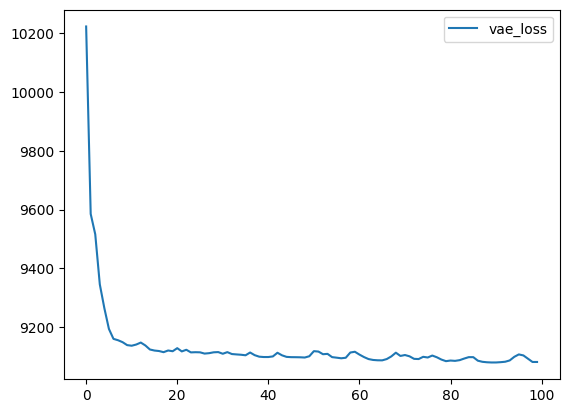

In [27]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['vae_loss']].plot()

# Latent space

1/1 [==============================] - 0s 12ms/step


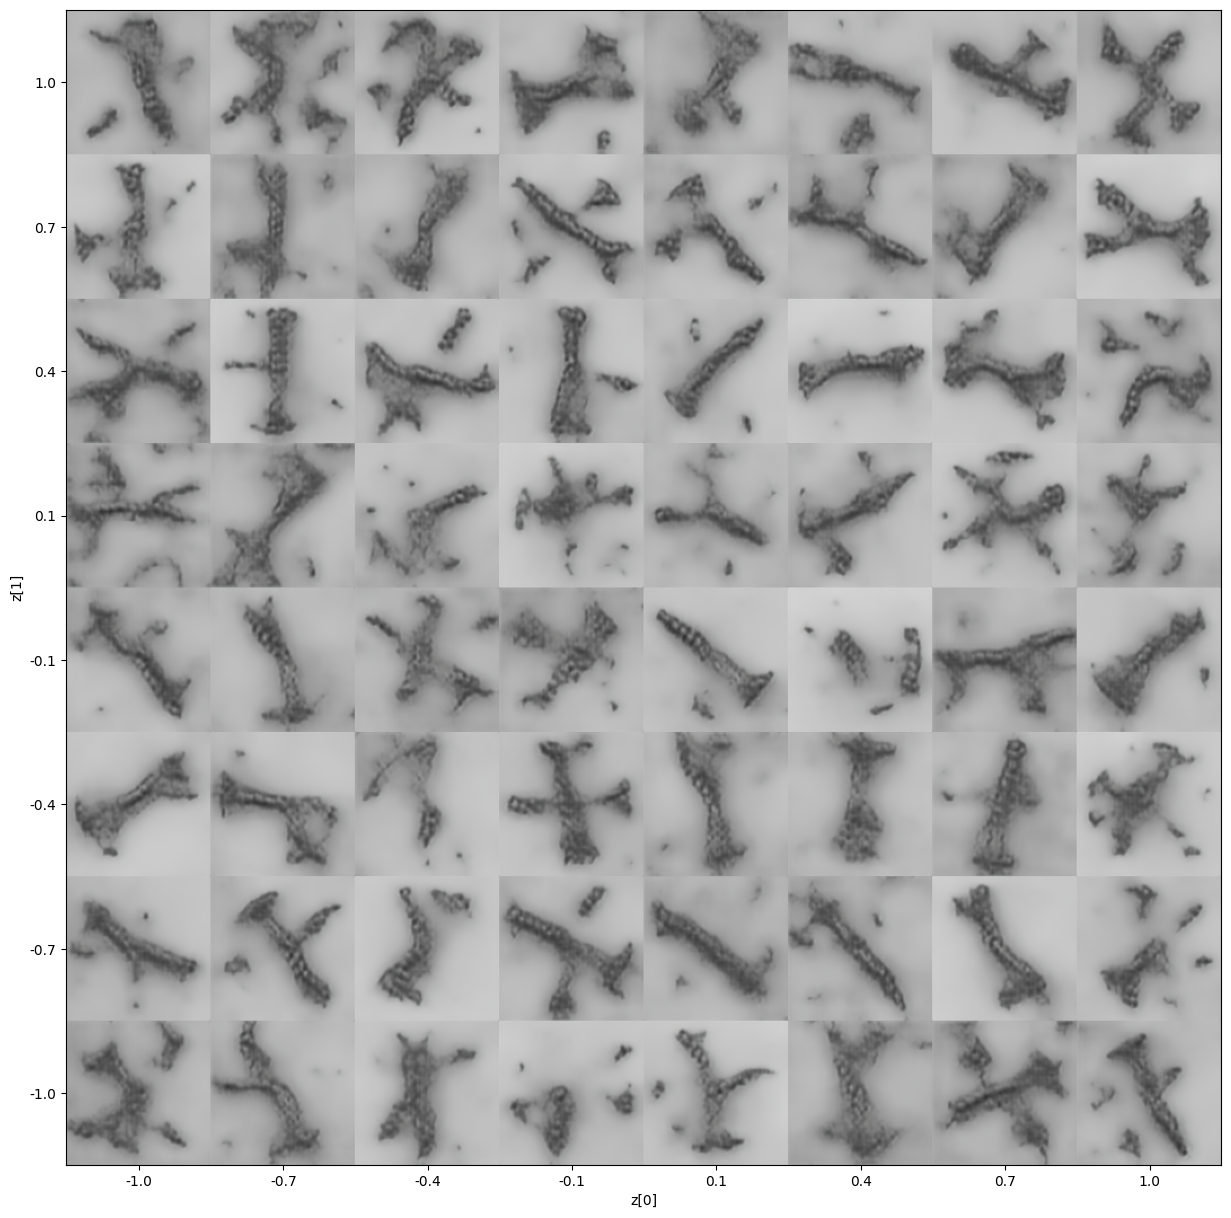

In [28]:
_ ,digit_size = image_size
scale = 1
def plot_latent_space(vae, n=8, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n,3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[2*random.random()-1 for i in range(latent_dim)]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size,3)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()


plot_latent_space(model)

# On training set

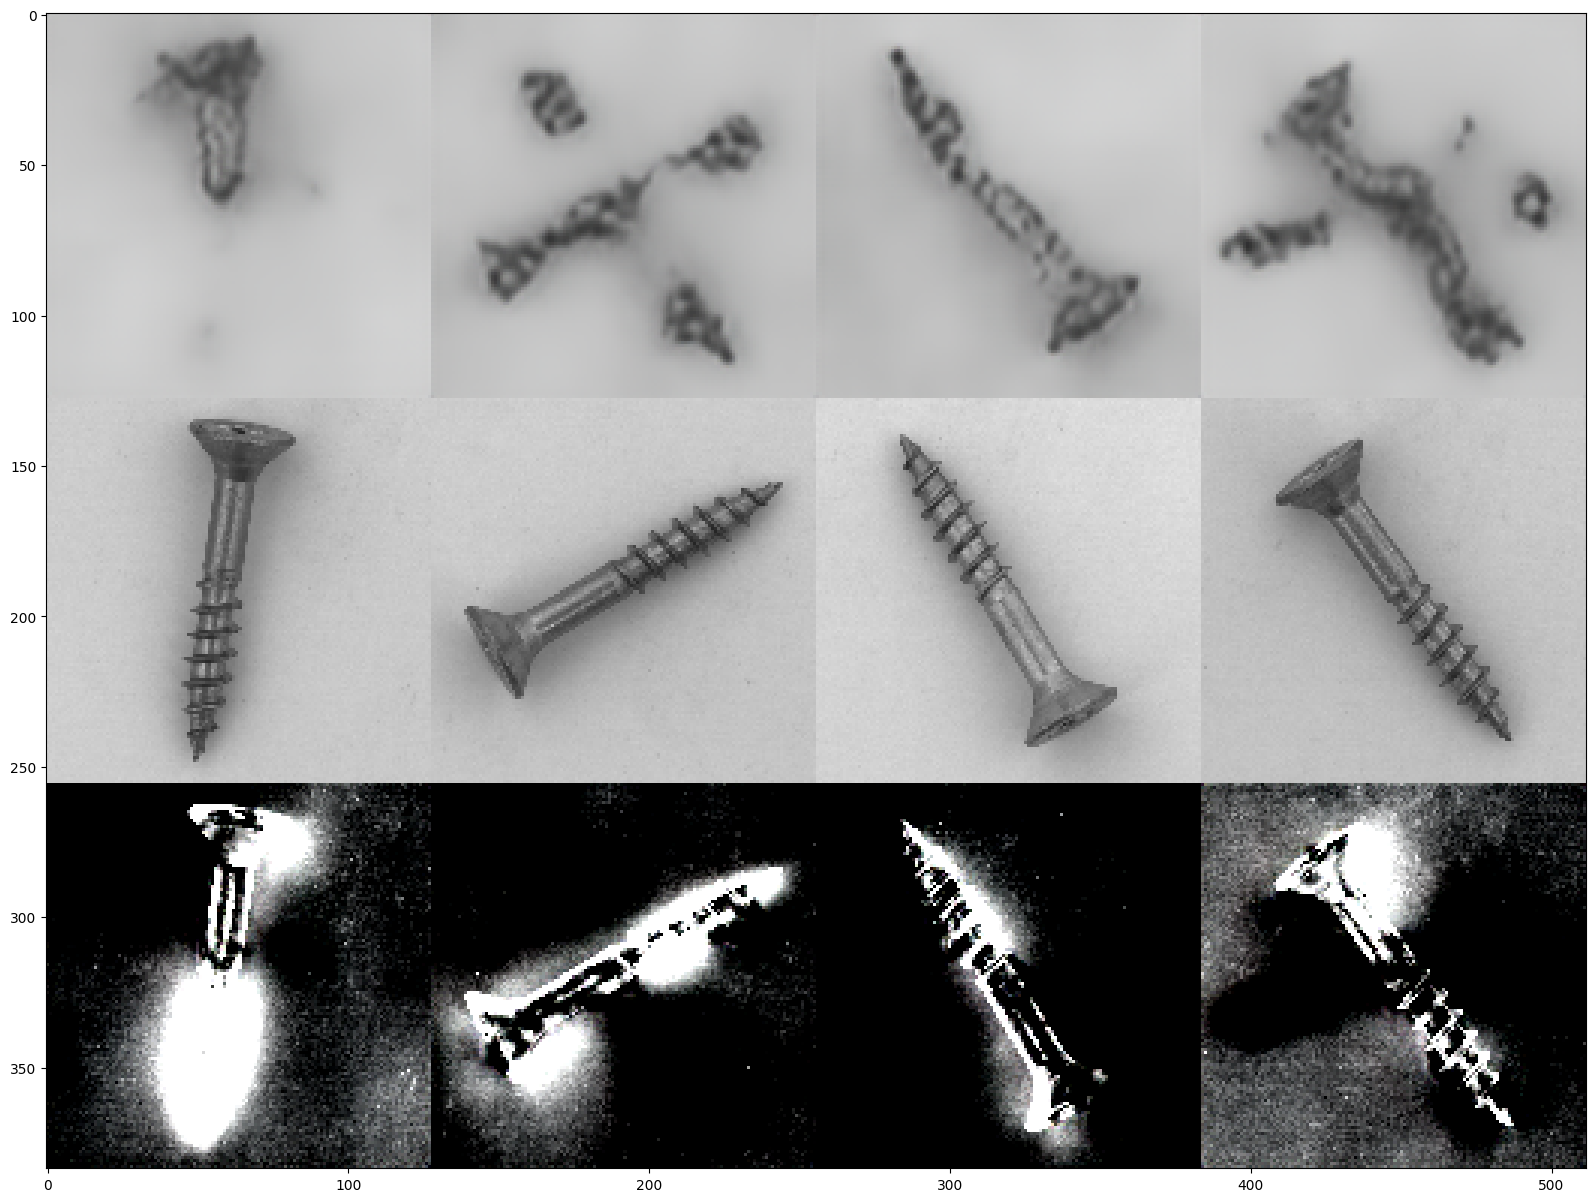

In [29]:
digit_size, _ = image_size
n = 4
figure = np.zeros((digit_size*3, digit_size * n,3))
img = list(ds)[0]

for i in range(n):
    _,b_img = model(img)
    a = list(b_img)[i]
    figure[
                 0*digit_size :  digit_size,
                i * digit_size :  (i+1)* digit_size,
            ] = a
    figure[
                 1*digit_size :  2*digit_size,
                i * digit_size :  (i+1)* digit_size,
            ] = list(img)[i]
    
    figure[
                 2*digit_size :  3*digit_size,
                i * digit_size :  (i+1)* digit_size,
            ] = (a-list(img)[i])*10


figsize = 5   
plt.figure(figsize=(figsize*n, figsize*3))
plt.imshow(figure)
plt.show()

# On test set

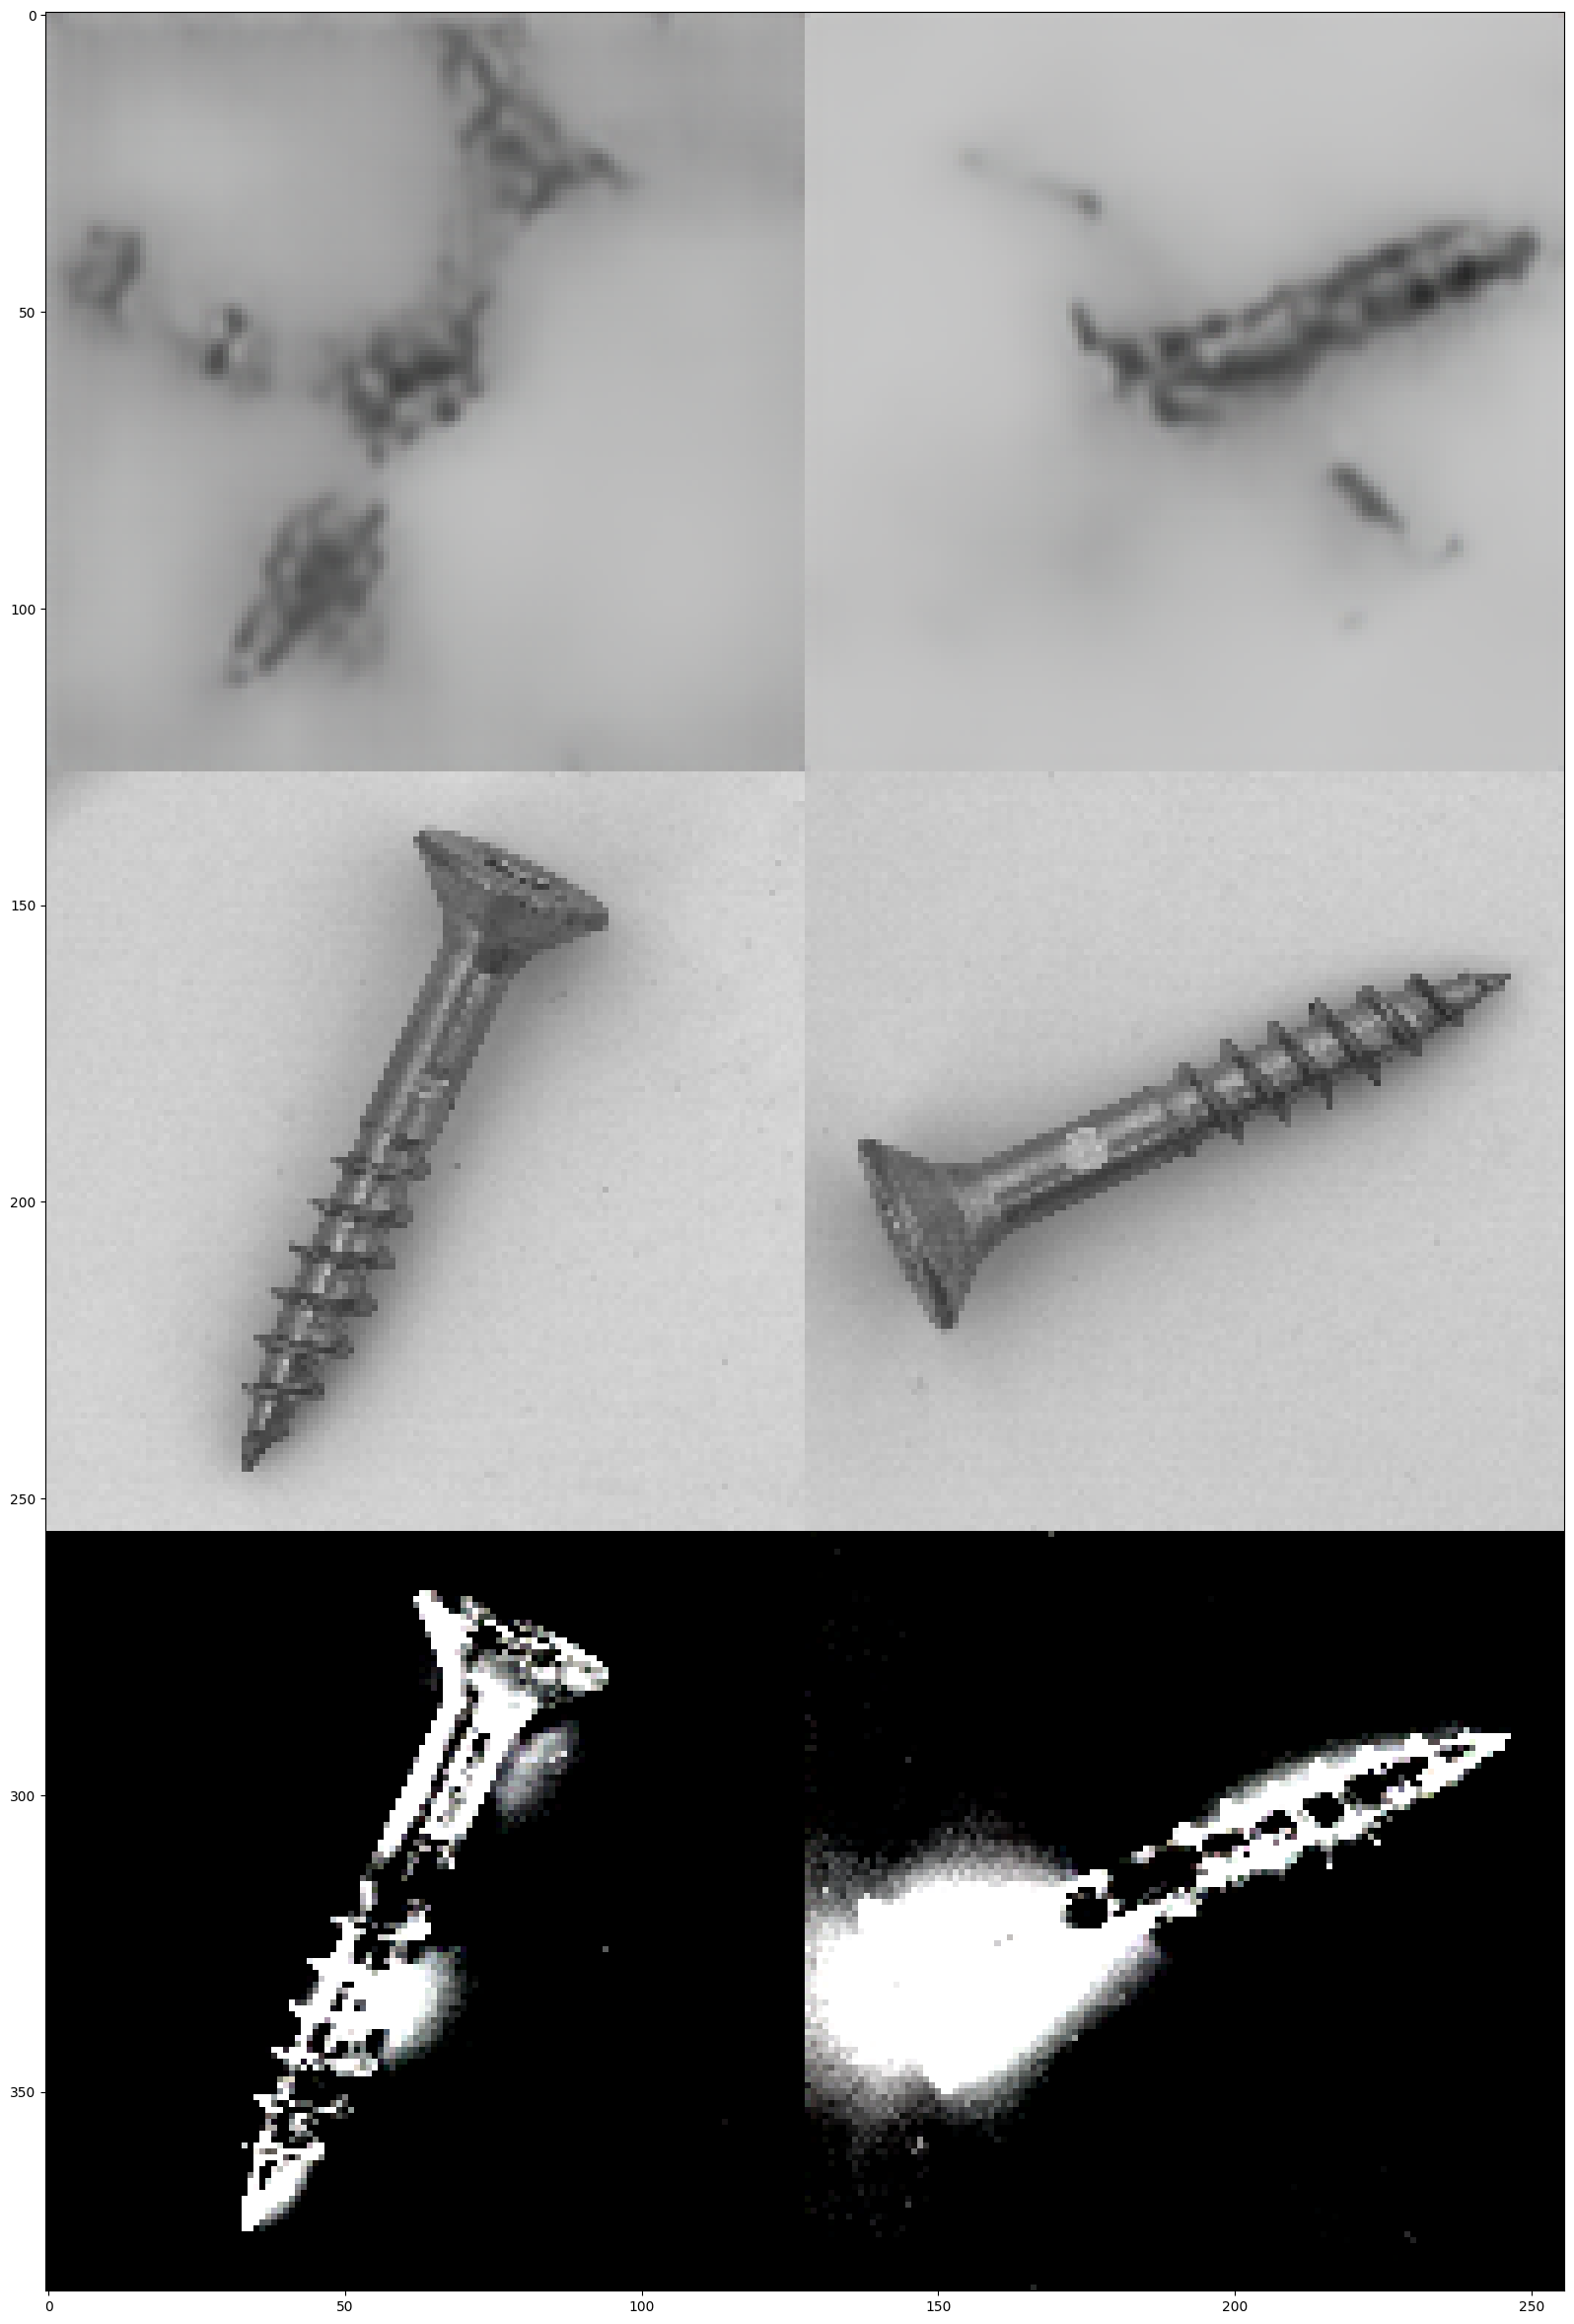

In [30]:
n = 2
figure = np.zeros((digit_size*3, digit_size * n,3))
img = list(ds_a)[0]
for i in range(n):
    _,b_img = model(img)
    a = list(b_img)[i]
    figure[
                 0*digit_size :  digit_size,
                i * digit_size :  (i+1)* digit_size,
            ] = a
    figure[
                 1*digit_size :  2*digit_size,
                i * digit_size :  (i+1)* digit_size,
            ] = list(img)[i]
    
    figure[
                 2*digit_size :  3*digit_size,
                i * digit_size :  (i+1)* digit_size,
            ] = (a-list(img)[i])*10

figsize = 10  
plt.figure(figsize=(figsize*n, figsize*3))
plt.imshow(figure)
plt.show()